In [48]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [49]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [50]:
# data load
df_name = 'esol'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O', 'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1']
0   -0.77
1   -3.30
2   -2.06
3   -7.87
4   -1.33
Name: logp, dtype: float64


In [51]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [52]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,-0.77
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,-3.30
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,-2.06
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,-7.87
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,1,0,0,-1.33


# t-sne

In [53]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## 사분위수

In [54]:
Q1 = np.percentile(target, 25)
Q2 = np.percentile(target, 50)
Q3 = np.percentile(target, 75)

idx_Q1 = np.where(target < Q1)[0]
idx_Q2 = np.where((target >= Q1) & (target < Q2))[0]
idx_Q3 = np.where((target >= Q2) & (target < Q3))[0]
idx_Q4 = np.where(target >= Q3)[0]

print(Q1, Q2, Q3)
print(idx_Q1, idx_Q2, idx_Q3, idx_Q4)

-4.3175 -2.86 -1.6
[   3    6    7    8    9   14   20   21   24   28   31   32   34   39
   40   48   52   54   56   58   60   65   69   71   76   77   86   89
   92   96   97  101  111  114  117  118  119  121  122  124  127  129
  139  158  161  166  167  169  170  172  175  181  184  185  187  188
  195  203  211  215  218  220  222  229  234  254  259  260  261  262
  263  268  272  275  286  288  289  290  293  294  297  299  303  304
  312  316  319  321  324  336  344  353  358  360  369  382  384  389
  390  397  398  405  414  417  420  421  422  423  429  430  432  434
  444  445  447  449  450  451  453  455  456  458  472  479  482  486
  491  497  498  499  500  510  517  522  529  531  547  548  552  554
  557  558  559  560  567  579  583  586  591  593  603  611  616  622
  623  625  632  637  640  643  645  646  650  654  655  661  668  672
  675  676  681  682  686  694  700  711  716  717  718  723  725  729
  734  736  743  744  751  755  756  759  767  768  775  7

In [55]:
# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)

idx_med4 = np.where(target < med1)[0]
idx_med5 = np.where((target >= med1) & (target < med2))[0]
idx_med6 = np.where(target >= med2)[0]

In [56]:
# 중앙값
med = np.percentile(target, 50)

idx_med1 = np.where(target < med)[0]
idx_med2 = np.where(target >= med)[0]

In [57]:
X = np.array(df_all_features)

In [58]:
perplexity = 30
method = 'barnes_hut' 
# default: barnes_hut, 'exact'

In [59]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method)
tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method)

X_tsne = tsne.fit_transform(X)
X_tsne3D = tsne3D.fit_transform(X)

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

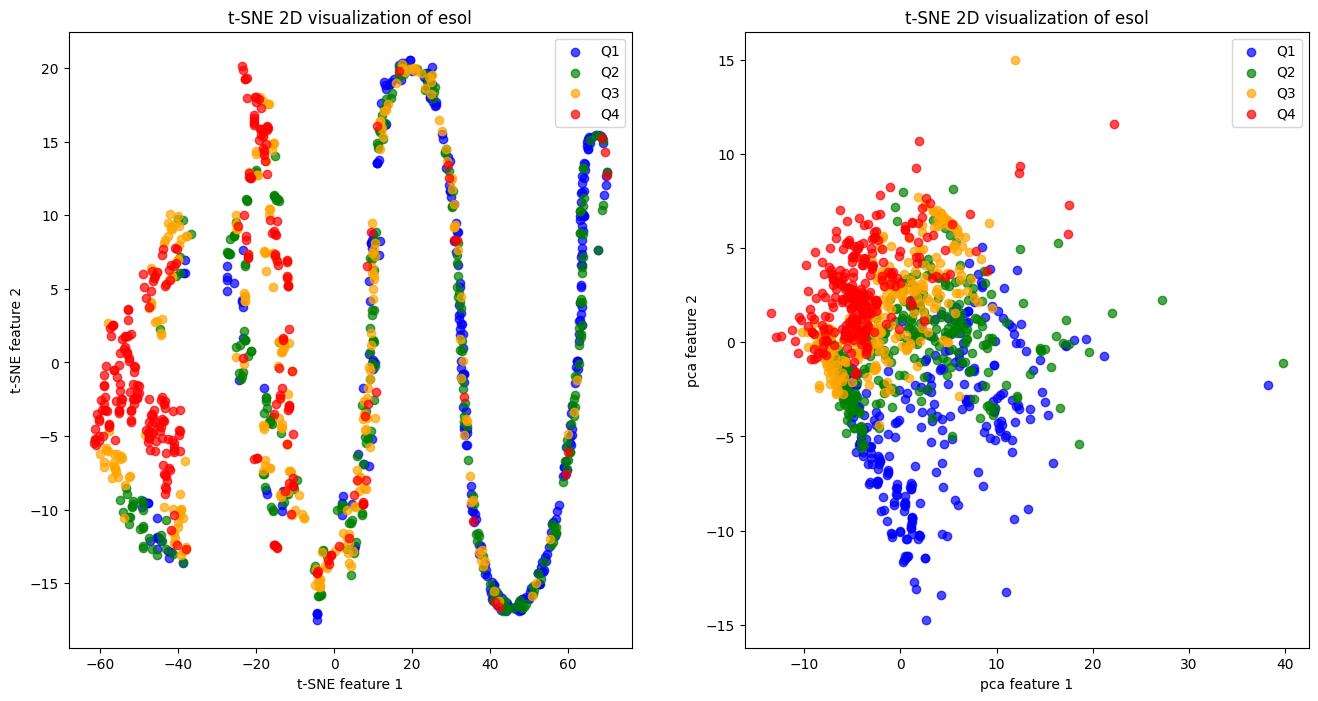

In [61]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_Q1, 0], X_tsne[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_Q2, 0], X_tsne[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax1.scatter(X_tsne[idx_Q3, 0], X_tsne[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax1.scatter(X_tsne[idx_Q4, 0], X_tsne[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# PCA
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_Q1, 0], X_pca2D[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q2, 0], X_pca2D[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q3, 0], X_pca2D[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q4, 0], X_pca2D[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax2.set_title(f't-SNE 2D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

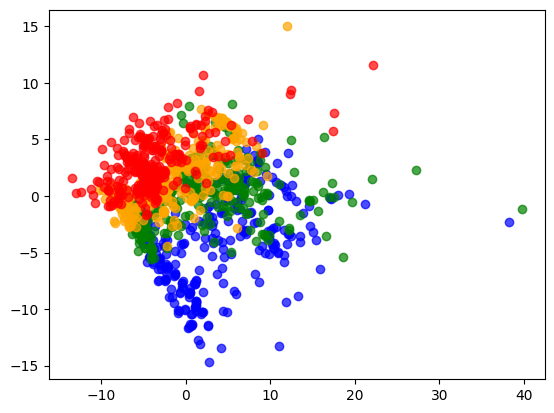

In [62]:
# PCA
plt.scatter(X_pca2D[idx_Q1, 0], X_pca2D[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
plt.scatter(X_pca2D[idx_Q2, 0], X_pca2D[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
plt.scatter(X_pca2D[idx_Q3, 0], X_pca2D[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
plt.scatter(X_pca2D[idx_Q4, 0], X_pca2D[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

# plt.set_title(f't-SNE 2D visualization of {df_name}')
# plt.set_xlabel('pca feature 1')
# plt.set_ylabel('pca feature 2')
# plt.legend()

# 저장
os.chdir(r'C:\Users\user\Desktop\연구\1. EGCN\성능\result\PCA')
plt.savefig(f'PCA_{df_name}4.png', dpi = 300, bbox_inches = 'tight')

plt.show()

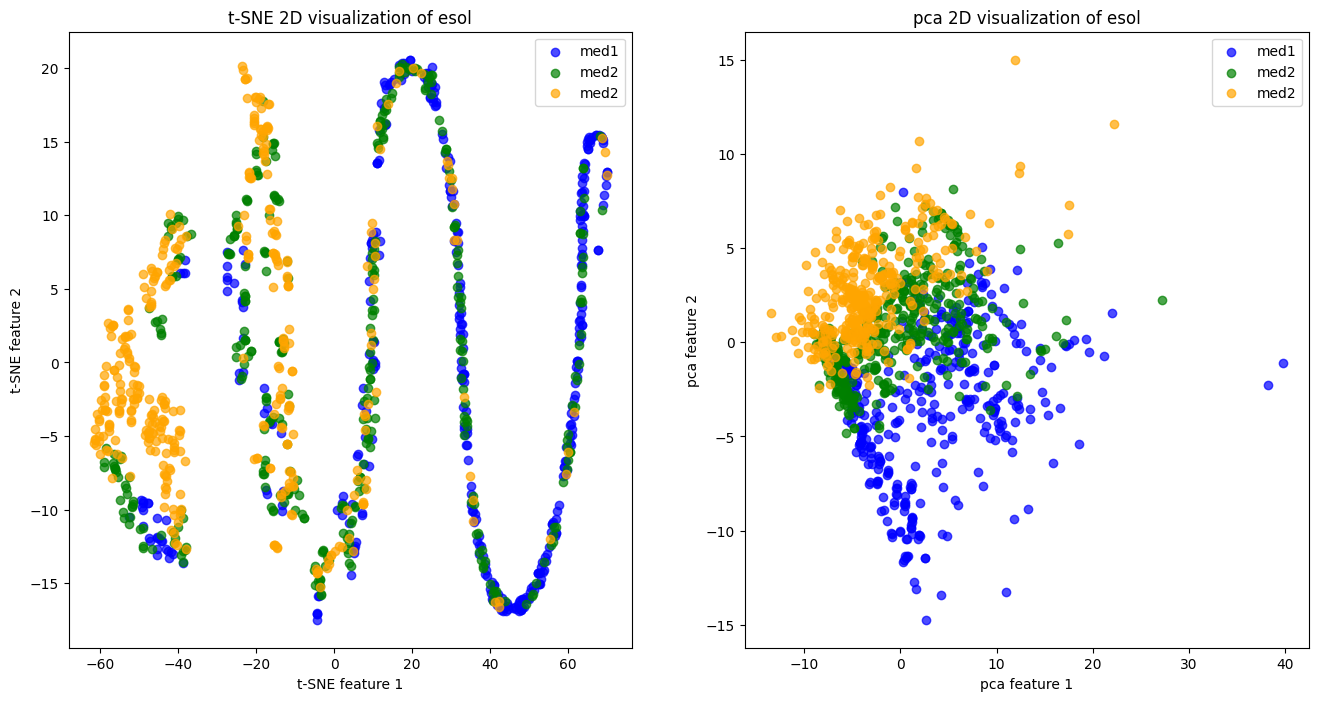

In [63]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_med4, 0], X_tsne[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_med5, 0], X_tsne[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax1.scatter(X_tsne[idx_med6, 0], X_tsne[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# pca
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_med4, 0], X_pca2D[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_med5, 0], X_pca2D[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax2.scatter(X_pca2D[idx_med6, 0], X_pca2D[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 2D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

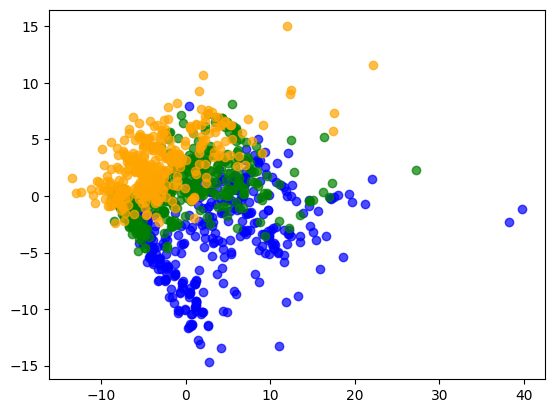

In [64]:
# pca
plt.scatter(X_pca2D[idx_med4, 0], X_pca2D[idx_med4, 1], label='med1', c='blue', alpha=0.7)
plt.scatter(X_pca2D[idx_med5, 0], X_pca2D[idx_med5, 1], label='med2', c='green', alpha=0.7)
plt.scatter(X_pca2D[idx_med6, 0], X_pca2D[idx_med6, 1], label='med2', c='orange', alpha=0.7)

# plt.title(f'PCA 2D visualization of {df_name}')
# plt.xlabel('pca feature 1')
# plt.ylabel('pca feature 2')
# plt.legend()

# 저장
os.chdir(r'C:\Users\user\Desktop\연구\1. EGCN\성능\result\PCA')
plt.savefig(f'PCA_{df_name}3.png', dpi = 300, bbox_inches = 'tight')

plt.show()

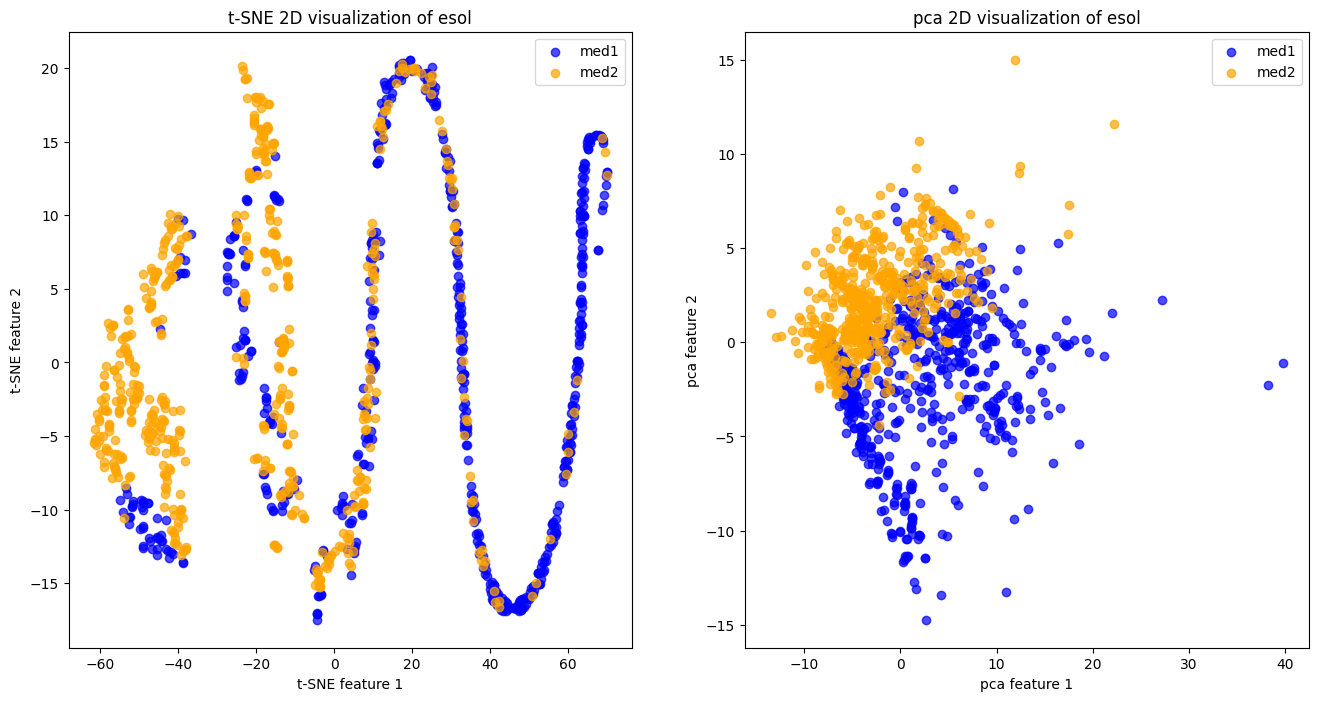

In [65]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_med1, 0], X_tsne[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_med2, 0], X_tsne[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# 시각화
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_med1, 0], X_pca2D[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_med2, 0], X_pca2D[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 2D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

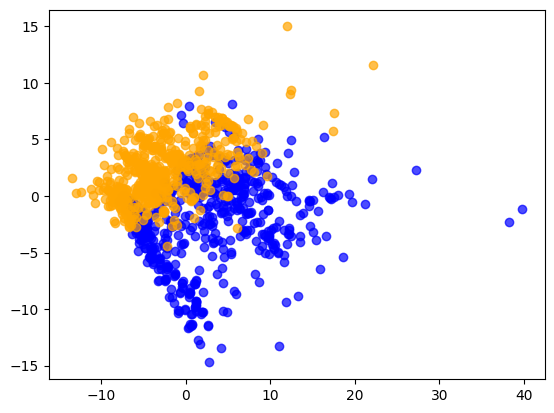

In [66]:
# 시각화
plt.scatter(X_pca2D[idx_med1, 0], X_pca2D[idx_med1, 1], label='med1', c='blue', alpha=0.7)
plt.scatter(X_pca2D[idx_med2, 0], X_pca2D[idx_med2, 1], label='med2', c='orange', alpha=0.7)

# plt.set_title(f'pca 2D visualization of {df_name}')
# plt.set_xlabel('pca feature 1')
# plt.set_ylabel('pca feature 2')
# plt.legend()

# 저장
os.chdir(r'C:\Users\user\Desktop\연구\1. EGCN\성능\result\PCA')
plt.savefig(f'PCA_{df_name}2.png', dpi = 300, bbox_inches = 'tight')

plt.show()

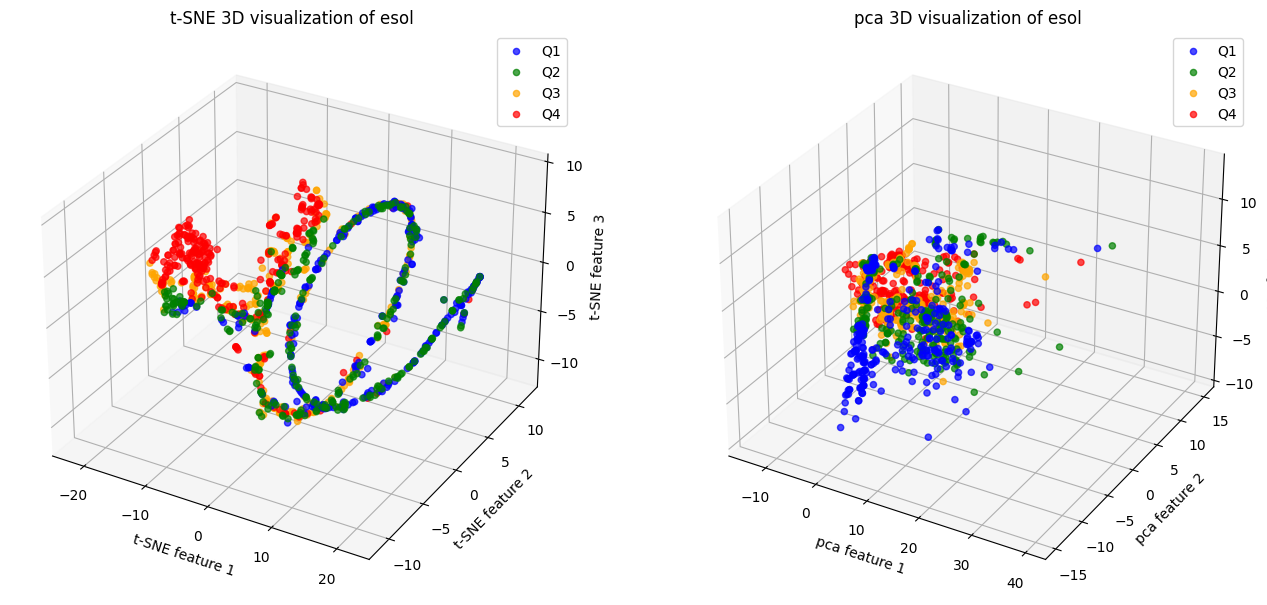

In [67]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_Q1, 0], X_tsne3D[idx_Q1, 1], X_tsne3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q2, 0], X_tsne3D[idx_Q2, 1], X_tsne3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q3, 0], X_tsne3D[idx_Q3, 1], X_tsne3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q4, 0], X_tsne3D[idx_Q4, 1], X_tsne3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_Q1, 0], X_pca3D[idx_Q1, 1], X_pca3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q2, 0], X_pca3D[idx_Q2, 1], X_pca3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q3, 0], X_pca3D[idx_Q3, 1], X_pca3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q4, 0], X_pca3D[idx_Q4, 1], X_pca3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.show()

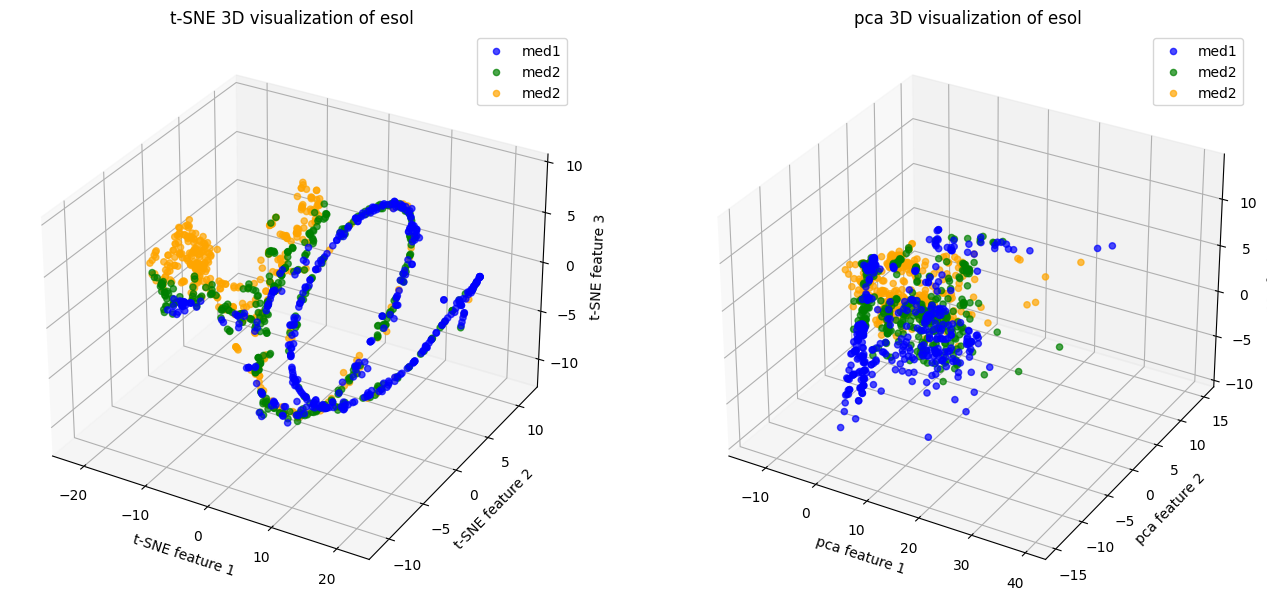

In [68]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_med4, 0], X_tsne3D[idx_med4, 1], X_tsne3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med5, 0], X_tsne3D[idx_med5, 1], X_tsne3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med6, 0], X_tsne3D[idx_med6, 1], X_tsne3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_med4, 0], X_pca3D[idx_med4, 1], X_pca3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_med5, 0], X_pca3D[idx_med5, 1], X_pca3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax2.scatter(X_pca3D[idx_med6, 0], X_pca3D[idx_med6, 1], X_pca3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.show()

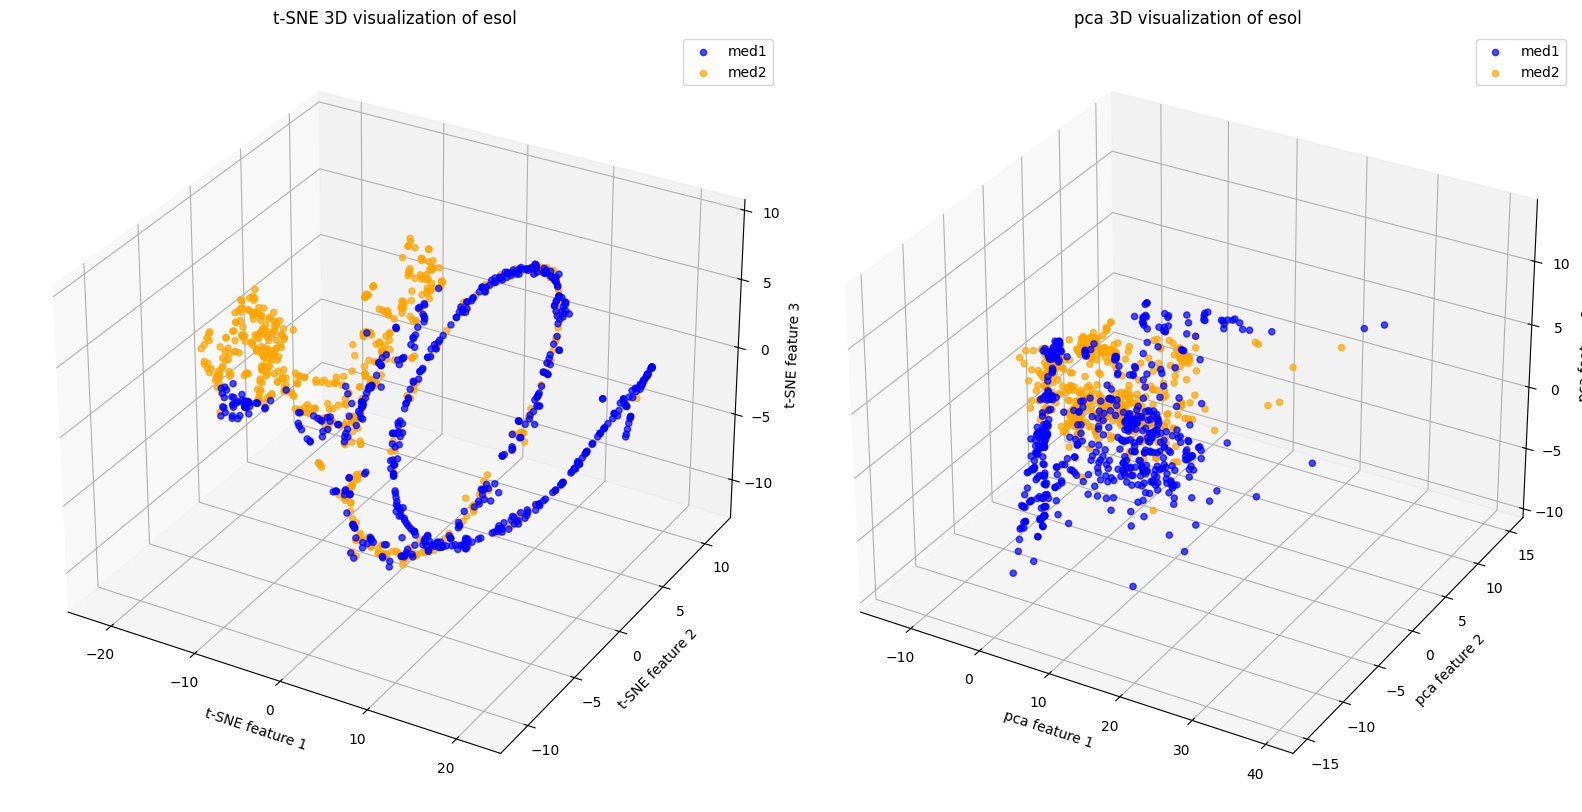

In [69]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_med1, 0], X_tsne3D[idx_med1, 1], X_tsne3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med2, 0], X_tsne3D[idx_med2, 1], X_tsne3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_med1, 0], X_pca3D[idx_med1, 1], X_pca3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_med2, 0], X_pca3D[idx_med2, 1], X_pca3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.tight_layout()
plt.show()